# FIT5149 - Applied Data Analysis: Assignment 1 (Monthly Stock Prediction: Regression Modelling)

This notebook focuses on the classification task of monthly stock prediction, where the goal is to predict the continuous `excess_return`.

To ensure modularity and reusability, all key functionalities demonstrated here have been refactored into the `src/` scripts directory. This allows us to keep the notebook clean while enabling easy experimentation and reuse across both tasks.

In [72]:
import pickle
import glob
from pathlib import Path

import pandas as pd
import numpy as np
from scipy.stats import randint, loguniform, uniform

import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, f1_score

from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, VotingRegressor
from sklearn.svm import SVC, SVR
import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor

## 1. Loading Data

Our dataset is made up of several key components, grouped into core data and optional macroeconomic data.

### Core Data
1. `stock_data.csv`: Historical monthly stock-level data.

2. `company_info.csv`: Company profile information, including sector, business model, business maturity, market cap category, revenue tier, and other attributes that describe each company.

3. `monashIndex.csv`: A benchmark index (similar to the S&P 500). For example, the excess_return label in our regression task is derived from the index_return column in this dataset.

4. `training_targets.csv`: Ground-truth labels for training. It contains:
- `outperform_binary`: For the classification task.
- `excess_return`: For the regression task.

5. `testing_targets.csv`: Similar to the training targets, but used for model evaluation and submission.

### Macroeconomic Data
1. `fed_funds_rate.csv`: The interest rate at which banks lend reserves to each other overnight.

2. `fed_inflation_rate.csv`: Measures the pace of price increases in the economy (commonly via CPI).

3. `fed_unemployment_rate.csv`: Percentage of the labor force that is unemployed but actively seeking work.

4. `us_5_year_treasury.csv`: Mid-term government bond yield, often compared against the 10-year rate.

5. `us_10_year_treasury.csv`: Long-term government bond yield, commonly treated as the benchmark “risk-free rate.”

6. `vix_index.csv`: A measure of expected near-term market volatility, derived from S&P 500 options (often referred to as the “fear index”).

In [2]:
def load_data(data_dir="../data"):
    # Primary data
    primary_data_dir = Path(data_dir)
    stock = pd.read_csv(primary_data_dir/"stock_data.csv")
    company = pd.read_csv(primary_data_dir/"company_info.csv")
    index = pd.read_csv(primary_data_dir/"monashIndex.csv")
    train_targets = pd.read_csv(primary_data_dir/"training_targets.csv")

    # Optional data
    optional_data_dir = primary_data_dir/"optional_data"
    optional_data_list = []
    for fname in optional_data_dir.glob("*.csv"):
        optional_data_list.append(pd.read_csv(fname))
    
    return stock, company, index, train_targets, optional_data_list

In [3]:
stock, company, index, train_targets, optional_data_list = load_data()

In [4]:
stock.head(3)

,stock_id,month_id,month_start_open_usd,month_end_close_usd,month_high_usd,month_low_usd,monthly_volume,intramonth_return,return_1m,return_3m,return_6m,intramonth_volatility,volatility_3m,volatility_6m,trading_days,avg_volume_3m,volume_ratio,price_range_ratio
0,US001,2020_01,120.192,107.326,123.486,107.035,84539259,-0.107045,-0.100669,-0.030041,-0.075676,0.253304,0.278396,0.201608,21,3182487.0,1.207,0.136875
1,US001,2020_02,108.252,101.868,111.641,99.636,91313882,-0.058974,-0.050854,-0.112968,-0.060752,0.259208,0.245523,0.192782,19,3686371.0,1.126,0.110905
2,US001,2020_03,103.301,93.178,105.622,77.841,177930833,-0.097995,-0.085299,-0.219214,-0.154874,0.892709,0.088364,0.213051,22,5360363.0,1.509,0.268931


In [5]:
company.head(3)

,stock_id,sector,business_model,geographic_focus,business_maturity,competitive_position,market_cap_category,revenue_tier,profitability_profile,asset_intensity,financial_strength
0,US001,Industrials,B2B,Domestic,Mature,Market_Leader,Large,Tier_1,Standard,Moderate,Stable
1,US002,Industrials,B2B,Global,Growth,Strong_Player,Mid,Tier_2,Standard,Capital_Intensive,Stable
2,US003,Healthcare,B2C,Global,Mature,Market_Leader,Large,Tier_1,High_Margin,Moderate,Stable


In [6]:
index.head(3)

,month_id,index_return,index_value
0,2020_01,-0.006452,99.354842
1,2020_02,-0.053054,94.083684
2,2020_03,-0.111379,83.604709


In [7]:
train_targets.head(3)

,month_id,stock_id,outperform_binary,excess_return
0,2020_01,US001,0,-0.100593
1,2020_02,US001,0,-0.005920
2,2020_03,US001,1,0.013384


In [8]:
len(optional_data_list)

6

## 2. Data Merging

Once we have the data loaded, we need to join (merge) them together under one table so that all features including the training labels. 

In [9]:
def merge_data(stock, company, index, train_targets, optional_data_list=None):
    # Add the test data to predict for month_id "2023_07"
    next_month_df = pd.DataFrame({"month_id": ["2023_07"]*len(company), "stock_id": company["stock_id"].values})
    new_stock = pd.concat([stock, next_month_df])
    
    # Merge/join the primary data
    df = pd.merge(new_stock, company, on=["stock_id"], how="left")
    df = pd.merge(df, index, on=["month_id"], how="left")
    df = pd.merge(df, train_targets, on=["month_id", "stock_id"], how="left")

    # Optionally merge the optional data
    if optional_data_list:
        for optional_data in optional_data_list:
            df = pd.merge(df, optional_data, on=["month_id"], how="left")
    
    return df

To give more flexibility, the `optional_data_list` parameter under the `merge_data()` function tells it whether to join the optional data or not. Notice that we have six additional columns after joining it with optional data.

In [10]:
df_without_optional_features = merge_data(stock, company, index, train_targets)
df_without_optional_features.head(3)

,stock_id,month_id,month_start_open_usd,month_end_close_usd,month_high_usd,month_low_usd,monthly_volume,intramonth_return,return_1m,return_3m,...,competitive_position,market_cap_category,revenue_tier,profitability_profile,asset_intensity,financial_strength,index_return,index_value,outperform_binary,excess_return
0,US001,2020_01,120.192,107.326,123.486,107.035,84539259.0,-0.107045,-0.100669,-0.030041,...,Market_Leader,Large,Tier_1,Standard,Moderate,Stable,-0.006452,99.354842,0.0,-0.100593
1,US001,2020_02,108.252,101.868,111.641,99.636,91313882.0,-0.058974,-0.050854,-0.112968,...,Market_Leader,Large,Tier_1,Standard,Moderate,Stable,-0.053054,94.083684,0.0,-0.005920
2,US001,2020_03,103.301,93.178,105.622,77.841,177930833.0,-0.097995,-0.085299,-0.219214,...,Market_Leader,Large,Tier_1,Standard,Moderate,Stable,-0.111379,83.604709,1.0,0.013384


In [11]:
df_with_optional_features = merge_data(stock, company, index, train_targets, optional_data_list)
df_with_optional_features.head(3)

,stock_id,month_id,month_start_open_usd,month_end_close_usd,month_high_usd,month_low_usd,monthly_volume,intramonth_return,return_1m,return_3m,...,index_return,index_value,outperform_binary,excess_return,fed_rate,inflation_rate,unemployment_rate,10y_treasury,5y_treasury,vix
0,US001,2020_01,120.192,107.326,123.486,107.035,84539259.0,-0.107045,-0.100669,-0.030041,...,-0.006452,99.354842,0.0,-0.100593,1.55,2.599768,3.6,1.52,1.33,13.94
1,US001,2020_02,108.252,101.868,111.641,99.636,91313882.0,-0.058974,-0.050854,-0.112968,...,-0.053054,94.083684,0.0,-0.005920,1.58,2.341317,3.5,1.13,0.91,19.63
2,US001,2020_03,103.301,93.178,105.622,77.841,177930833.0,-0.097995,-0.085299,-0.219214,...,-0.111379,83.604709,1.0,0.013384,0.65,1.494040,4.4,0.70,0.38,57.74


## 3. Feature Engineering

In a time series setting like this, the values in stock_data.csv are only available up to June 2023 (2023_06). To predict labels such as outperform_binary for July 2023 (2023_07), we would need that month’s features (returns, volatility, volumes, fundamentals, etc.).

The problem: we won’t actually know those future values yet. If the model had access to them during training, it would be “peeking” into the future — essentially cheating — since it would already know the real price values we are trying to forecast.

To solve this, we create proxy features that rely only on information available at or before the prediction month. These are the strategies we adopt:

1. **Static company features**

- Characteristics that don’t change frequently, or at all (e.g., sector, business model, market cap category, maturity, revenue tier).
- Derived from `company_info.csv`.

2. **Rolling / lagged historical features**

- Instead of using future values directly, we compute aggregates (mean, median, std, sum, etc.) over past time windows (e.g., 3M, 6M, 12M).
- Example: when predicting `2023_01`, instead of plugging in that month’s `return_3m` (which we don’t know yet), we calculate rolling averages or medians of past returns up to December 2022.

3. **Handling missing values at the start of the series**

- At the beginning of the dataset (e.g., January 2020), rolling or lagged values aren’t available because there’s no prior data.
- These early months produce some NaN values. Since they represent only a small portion of the data, we can handle them with simple forward-fill or backward-fill strategies.

In [12]:
def impute_missing_columns(df, imputation_method):    
    for column in df.columns:
        if column in ["month_id", "stock_id"]:  # never impute ID columns
            continue
        
        if imputation_method == "ffill":
            df[column] = df[column].fillna(method="ffill")
        elif imputation_method == "median":
            df[column] = df[column].fillna(df[column].median())
    
    return df

def compute_rolling_statistic_features(df, macro_cols):
    grouped = df.groupby('stock_id')

    # Price-based returns 
    for window in [3, 6, 12]:
        df[f'intramonth_return_rolling_mean_{window}m']   = grouped['intramonth_return'].transform(lambda x: x.rolling(window, min_periods=1).mean())
        df[f'intramonth_return_rolling_std_{window}m']    = grouped['intramonth_return'].transform(lambda x: x.rolling(window, min_periods=1).std())
        df[f'intramonth_return_rolling_median_{window}m'] = grouped['intramonth_return'].transform(lambda x: x.rolling(window, min_periods=1).median())

    # Lagged returns 
    for col in ['return_1m', 'return_3m', 'return_6m']:
        for lag in [1, 2]:
            df[f'{col}_lagged_{lag}'] = grouped[col].shift(lag)

    # Volatility features
    for col, windows in [
        ('intramonth_volatility', [3, 6, 12]),
        ('volatility_3m', [3, 6]),
        ('volatility_6m', [3, 6])
    ]:
        for window in windows:
            df[f'{col}_rolling_mean_{window}m'] = grouped[col].transform(lambda x: x.rolling(window, min_periods=1).mean())
            df[f'{col}_rolling_std_{window}m']  = grouped[col].transform(lambda x: x.rolling(window, min_periods=1).std())

    # Volume features
    for col, windows in [
        ('monthly_volume', [3, 6]),
        ('avg_volume_3m', [3, 6]),
        ('volume_ratio', [3, 6])
    ]:
        for window in windows:
            df[f'{col}_rolling_mean_{window}m'] = grouped[col].transform(lambda x: x.rolling(window, min_periods=1).mean())
            df[f'{col}_rolling_sum_{window}m']  = grouped[col].transform(lambda x: x.rolling(window, min_periods=1).sum())

    # Price range
    df['price_range'] = df['month_high_usd'] - df['month_low_usd']
    for window in [3, 6, 12]:
        df[f'price_range_rolling_mean_{window}m']       = grouped['price_range'].transform(lambda x: x.rolling(window, min_periods=1).mean())
        df[f'price_range_ratio_rolling_mean_{window}m'] = grouped['price_range_ratio'].transform(lambda x: x.rolling(window, min_periods=1).mean())

    # Index rolling features
    for window in [3, 6]:
        df[f'index_return_rolling_mean_{window}m'] = grouped['index_return'].transform(lambda x: x.rolling(window, min_periods=1).mean())
        df[f'index_return_rolling_std_{window}m']  = grouped['index_return'].transform(lambda x: x.rolling(window, min_periods=1).std())

    # Additional features
    if macro_cols:
        for col in macro_cols:
            for window in [3, 6, 12]:
                df[f'{col}_rolling_mean_{window}m'] = df.groupby('month_id')[col].transform(lambda x: x.rolling(window, min_periods=1).mean())
                df[f'{col}_rolling_std_{window}m']  = df.groupby('month_id')[col].transform(lambda x: x.rolling(window, min_periods=1).std())

    return df
    
def handle_missing_rolling_features(df, strategy="drop", fill_value=0):
    rolling_cols = [c for c in df.columns if "lag" in c or "rolling" in c]
    if strategy == "drop":
        df = df.dropna(subset=rolling_cols)
    elif strategy == "fill":
        df[rolling_cols] = df[rolling_cols].fillna(fill_value)
    elif strategy == "ffill":
        df[rolling_cols] = df[rolling_cols].fillna(method="ffill")
    elif strategy == "bfill":
        df[rolling_cols] = df[rolling_cols].fillna(method="bfill")

    return df

def build_training_data(df, imputation_method, macro_cols=None,
                        build_additional_features=False, handle_missing_rolling_features_strategy="bfill"):
    train_df = df.copy()
    train_df = impute_missing_columns(train_df, imputation_method=imputation_method)
    train_df = train_df.sort_values(by=["stock_id", "month_id"])
    
    if build_additional_features:
        train_df = compute_rolling_statistic_features(train_df, macro_cols)
        train_df = handle_missing_rolling_features(train_df, strategy=handle_missing_rolling_features_strategy)
    
    train_df["outperform_binary"] = df["outperform_binary"]
    train_df["excess_return"] = df["excess_return"]
    
    return train_df

In [13]:
train_df = build_training_data(df_without_optional_features, imputation_method="ffill",
                               macro_cols=None, 
                               build_additional_features=False,
                               handle_missing_rolling_features_strategy="bfill")

C:\Users\Archel\AppData\Local\Temp\ipykernel_20044\3088241577.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method="ffill")


Make sure that the only missing columns are the labels `outperform_binary` and `excess_return` for the test data.

In [14]:
has_null_df = train_df.isnull().sum().to_frame(name="count").reset_index()
has_null_df.query("count > 0")

,index,count
30,outperform_binary,616
31,excess_return,616


## 4. Data Split & Cross Validation Setting

We split the dataset into training and test based on time:

- All data prior to `2023_07` -> training set
- Data for `2023_07` -> test set (held-out for final evaluation)

Unlike standard ML problems, splitting time series data requires special care:

- A random split would leak future information into the training set.
- We also cannot freely mix data across different companies, since each stock has its own dynamics. Mixing timelines would confuse the model and break the temporal ordering of events.

To respect the temporal structure, we use time-series cross-validation (CV):

1. Group and sort the data by `stock_id` and `month_id`.

2. Rolling/expanding split by `month_id`:

- Start with a warm-up training window (e.g., 12 months from `2021_01` to `2021_12`). Warm-up window ensures that we have enough history for rolling/lagged features. If we decide the validation month too early, those values will be `NaN` (empty). It also promotes training stability and provides more variability in 1 year.

- Use the next month (`2022_01`) as validation.

3. Iterate forward in time: each fold expands (or slides) the training window and shifts the validation month forward.

4. Stop when the validation reaches the last available month (`2023_06`).

This approach mimics the real-world forecasting process: at any point, the model can only learn from the past and must predict the immediate future.

In [15]:
def split_data(df, task):
    train_df = df[df['month_id'] <= "2023_06"]
    test_df = df[df['month_id'] == "2023_07"]

    X_train = train_df.drop(columns=["outperform_binary", "excess_return"], axis=1)
    X_test = test_df.drop(columns=["outperform_binary", "excess_return"], axis=1)
    if task == "classification":
        y_train = train_df['outperform_binary'].astype(int)
    elif task == "regression":
        y_train = train_df['excess_return'].astype(float)

    return X_train, y_train, X_test

def time_series_cv_splits(df, warmup=12, n_splits=5, window_type="expanding"):
    months = sorted(df["month_id"].unique())
    total_months = len(months)

    for i in range(warmup, min(total_months, warmup + n_splits)):
        if window_type == "expanding":
            train_months = months[:i]     
        elif window_type == "sliding":
            start_idx = max(0, i - warmup)
            train_months = months[start_idx:i] 

        val_month = months[i]        
        train_idx = df[df["month_id"].isin(train_months)].index
        val_idx   = df[df["month_id"] == val_month].index

        yield train_idx, val_idx

In [16]:
X_train_clf, y_train_clf, X_test_clf = split_data(train_df, task="regression")

To provide more flexibility, the cross validation split can be done in two ways:

1. Expanding window: Training set keeps expanding, validation is always the next month (or next k months).

2. Sliding window: Training window has fixed length (e.g., 12 months). Slide the window forward by 1 month each fold: train on `[t..t+11]`, validate on month `t+12`.

In [17]:
for fold, (train_idx, val_idx) in enumerate(time_series_cv_splits(train_df, window_type="expanding")):
    print(f"Fold {fold+1}: Train months={train_df.loc[train_idx,'month_id'].unique()[[0,-1]]}, "
          f"Val month={train_df.loc[val_idx,'month_id'].unique()[0]}")

Fold 1: Train months=['2020_01' '2020_12'], Val month=2021_01
Fold 2: Train months=['2020_01' '2021_01'], Val month=2021_02
Fold 3: Train months=['2020_01' '2021_02'], Val month=2021_03
Fold 4: Train months=['2020_01' '2021_03'], Val month=2021_04
Fold 5: Train months=['2020_01' '2021_04'], Val month=2021_05


In [18]:
for fold, (train_idx, val_idx) in enumerate(time_series_cv_splits(train_df, window_type="sliding")):
    print(f"Fold {fold+1}: Train months={train_df.loc[train_idx,'month_id'].unique()[[0,-1]]}, "
          f"Val month={train_df.loc[val_idx,'month_id'].unique()[0]}")

Fold 1: Train months=['2020_01' '2020_12'], Val month=2021_01
Fold 2: Train months=['2020_02' '2021_01'], Val month=2021_02
Fold 3: Train months=['2020_03' '2021_02'], Val month=2021_03
Fold 4: Train months=['2020_04' '2021_03'], Val month=2021_04
Fold 5: Train months=['2020_05' '2021_04'], Val month=2021_05


## 5. Modelling

### 5.1. Baseline (Dummy Model)

Before training more complex models, we establish a baseline using a simple DummyRegressor from scikit-learn. This classifier can generate predictions using different strategies:

- Mean
- Median
- Quantile
- Constant

This gives us a baseline model that predicts labels with a single value which acts as a lower bound — any meaningful model should outperform this model.

In [19]:
def create_dummy_pipeline(X_train, task):
    if task == "classification":
        dummy_pipeline = Pipeline(steps=[
            ("model", DummyClassifier(strategy="uniform", random_state=42)) 
        ])
    elif task == "regression":
        dummy_pipeline = Pipeline(steps=[
            ("model", DummyRegressor(strategy="median")) 
        ])

    return dummy_pipeline

def train_single_pipeline(model_pipeline, X, y, df, cv_splits=30, task="classification",
                          window_type="expanding", warmup=12):  

    oof_preds = np.zeros(len(X))
    metric_scores = []

    for fold, (train_idx, val_idx) in enumerate(time_series_cv_splits(df, 
                                                                      warmup=warmup,
                                                                      n_splits=cv_splits,
                                                                      window_type=window_type)):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

        # Fit model
        model_pipeline.fit(X_train_cv, y_train_cv)

        # Predictions
        if task == "classification":
            val_preds = model_pipeline.predict(X_val_cv)
            metric = f1_score(y_val_cv, val_preds)
        elif task == "regression":
            val_preds = model_pipeline.predict(X_val_cv)
            metric = np.sqrt(mean_squared_error(y_val_cv, val_preds))

        oof_preds[val_idx] = val_preds
        metric_scores.append(metric)

    if task == "classification":
        print(f"Mean F1 Score across folds: {np.mean(metric_scores):.4f}")
    elif task == "regression":
        print(f"Mean RMSE across folds: {np.mean(metric_scores):.4f}")

    return metric_scores

In [20]:
dummy_pipeline_clf = create_dummy_pipeline(X_train_clf, task="regression")
_ = train_single_pipeline(dummy_pipeline_clf, X_train_clf, y_train_clf, train_df, cv_splits=30, task="regression")

Mean RMSE across folds: 0.0938


Even with just the median, the dummy model already achieved 0.09 RMSE! Our goal is to train models that achieve better RMSE.

### 5.2. Initial Model Training

Our dataset contains both numerical and categorical features. Since many machine learning algorithms require categorical variables to be encoded as numeric, we apply preprocessing where necessary. However, some models such as Random Forest can handle categorical features directly without explicit encoding.

We further distinguish categorical features into two groups:

- Ordinal features: categories with a natural order (e.g., sector, business_model).
- Nominal features: categories without inherent ordering (treated as standard categorical variables).

In this notebook, we evaluate five baseline models: Logistic Regression, Random Forest, Support Vector Machine (SVM), XGBoost, and CatBoost. Each model is first trained using its default hyperparameters (as provided by `scikit-learn` or the respective library) to enable a fair initial comparison.

In [21]:
def get_features(X_train):
    features_to_exclude = ['month_id', 'stock_id', 'outperform_binary', 'excess_return']
    categorical_features = ["sector", "business_model"]
    ordinal_features = [column for column in X_train.columns if X_train[column].dtype == "object" and column not in categorical_features + features_to_exclude]
    numerical_features = [column for column in X_train.columns if "lag" in column or "rolling" in column]

    return categorical_features, ordinal_features, numerical_features

def create_feature_preprocessor(categorical_features, ordinal_features, numerical_features):
    preprocessor = ColumnTransformer(
        transformers=[
            ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_features),
            ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_features),
            ("num", StandardScaler(), numerical_features)
        ],
        remainder="drop"
    )

    return preprocessor

Utilising the `Pipeline` class from `scikit-learn` makes model building and experimenting much easier. Since we are using the same column transformer and steps, we just need to replace the training part with the respective models.

In [33]:
def create_linear_regression_pipeline(X_train, task):
    categorical_features, ordinal_features, numerical_features = get_features(X_train)
    preprocessor = create_feature_preprocessor(categorical_features, ordinal_features, numerical_features)
    if task == "classification":
        lr_pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", LogisticRegression(max_iter=1000, random_state=42))
        ])
    elif task == "regression":
        lr_pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", ElasticNet(random_state=42)) 
        ])

    return lr_pipeline

def create_random_forest_pipeline(X_train, task):
    categorical_features, ordinal_features, numerical_features = get_features(X_train)
    preprocessor = create_feature_preprocessor(categorical_features, ordinal_features, numerical_features)
    if task == "classification":
        rf_pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", RandomForestClassifier(n_jobs=-1, random_state=42)) 
        ])
    elif task == "regression":
        rf_pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", RandomForestRegressor(n_jobs=-1, random_state=42)) 
        ])

    return rf_pipeline

def create_svm_pipeline(X_train, task):
    categorical_features, ordinal_features, numerical_features = get_features(X_train)
    preprocessor = create_feature_preprocessor(categorical_features, ordinal_features, numerical_features)
    if task == "classification":
        svm_pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", SVC(probability=False, random_state=42)) 
        ])
    elif task == "regression":
        svm_pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", SVR()) 
        ])

    return svm_pipeline

def create_xgb_pipeline(X_train, task):
    categorical_features, ordinal_features, numerical_features = get_features(X_train)
    preprocessor = create_feature_preprocessor(categorical_features, ordinal_features, numerical_features)
    if task == "classification":
        xgb_pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", xgb.XGBClassifier(random_state=42)) 
        ])
    elif task == "regression":
        xgb_pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", xgb.XGBRegressor(random_state=42)) 
        ])

    return xgb_pipeline

def create_catboost_pipeline(X_train, task):
    categorical_features, ordinal_features, numerical_features = get_features(X_train)
    preprocessor = create_feature_preprocessor(categorical_features, ordinal_features, numerical_features)
    if task == "classification":
        catboost_pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", CatBoostClassifier(random_state=42, verbose=0)) 
        ])
    elif task == "regression":
        catboost_pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", CatBoostRegressor(random_state=42, verbose=0)) 
        ])

    return catboost_pipeline

def compare_classification_models(model_pipelines, X_train, y_train, train_df, task, cv_splits):
    evaluation_dict = {"algorithm": [], "rmse_scores": [], "mean_rmse_score": []}
    for model_pipeline in model_pipelines:
        rmse_scores = train_single_pipeline(model_pipeline[1], X_train, y_train, train_df, cv_splits, task)
        mean_rmse_score = np.mean(rmse_scores)
        evaluation_dict["algorithm"].append(model_pipeline[0])
        evaluation_dict["rmse_scores"].append(rmse_scores)
        evaluation_dict["mean_rmse_score"].append(mean_rmse_score)

    return pd.DataFrame(evaluation_dict)

Since our dataset is available in two versions with optional features and without optional features, we begin by fitting all five baseline models on both variants. This allows us to evaluate whether the optional features contribute meaningful predictive power and lead to improvements in model performance.

In [23]:
train_df_without_optional_features = build_training_data(df_without_optional_features, 
                                                         imputation_method="ffill",
                                                         macro_cols=[], 
                                                         build_additional_features=True,
                                                         handle_missing_rolling_features_strategy='bfill')

train_df_with_optional_features = build_training_data(df_with_optional_features, 
                                                      imputation_method="ffill",
                                                      macro_cols=["fed_rate", "inflation_rate", "unemployment_rate", 
                                                                  "10y_treasury", "5y_treasury", "vix"], 
                                                      build_additional_features=True,
                                                      handle_missing_rolling_features_strategy='bfill')

C:\Users\Archel\AppData\Local\Temp\ipykernel_20044\3088241577.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method="ffill")
C:\Users\Archel\AppData\Local\Temp\ipykernel_20044\3088241577.py:76: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[rolling_cols] = df[rolling_cols].fillna(method="bfill")
C:\Users\Archel\AppData\Local\Temp\ipykernel_20044\3088241577.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method="ffill")
C:\Users\Archel\AppData\Local\Temp\ipykernel_20044\3088241577.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

Split the data to train/test features and labels.

In [24]:
X_train_without_optional_features_clf, y_train_without_optional_features_clf, X_test_without_optional_features_clf = split_data(train_df_without_optional_features, task="regression")
X_train_with_optional_features_clf, y_train_with_optional_features_clf, X_test_with_optional_features_clf = split_data(train_df_with_optional_features, task="regression")

Train five models with data without optional features

In [25]:
lr_pipeline = create_linear_regression_pipeline(X_train_without_optional_features_clf, task="regression")
rf_pipeline = create_random_forest_pipeline(X_train_without_optional_features_clf, task="regression")
svm_pipeline = create_svm_pipeline(X_train_without_optional_features_clf, task="regression")
xgb_pipeline = create_xgb_pipeline(X_train_without_optional_features_clf, task="regression")
catboost_pipeline = create_catboost_pipeline(X_train_without_optional_features_clf, task="regression")

model_pipelines = [("logistic_regression", lr_pipeline), 
                   ("random_forest", rf_pipeline),
                   ("support_vector_classifier", svm_pipeline),
                   ("xgboost", xgb_pipeline),
                   ("catboost", catboost_pipeline)]

model_comparison_df = compare_classification_models(model_pipelines, 
                                                    X_train_without_optional_features_clf, 
                                                    y_train_without_optional_features_clf, 
                                                    train_df, task="regression", cv_splits=30)


Mean RMSE across folds: 0.0380
Mean RMSE across folds: 0.0409
Mean RMSE across folds: 0.0487
Mean RMSE across folds: 0.0397
Mean RMSE across folds: 0.0355


In [28]:
model_comparison_df.sort_values(by=["mean_rmse_score"], ascending=False)

,algorithm,rmse_scores,mean_rmse_score
2,support_vector_classifier,"[0.07478882328540172, 0.08282334395885538, 0.0...",0.048711
1,random_forest,"[0.05703453311854909, 0.07407708250145052, 0.0...",0.040918
3,xgboost,"[0.049308000587184285, 0.06587039284877305, 0....",0.039745
0,logistic_regression,"[0.08923228263299259, 0.06643079844278138, 0.0...",0.038002
4,catboost,"[0.047410445515242906, 0.0639736797180486, 0.0...",0.035502


Now train five models with data with optional features

In [29]:
lr_pipeline = create_linear_regression_pipeline(X_train_with_optional_features_clf, task="regression")
rf_pipeline = create_random_forest_pipeline(X_train_with_optional_features_clf, task="regression")
svm_pipeline = create_svm_pipeline(X_train_with_optional_features_clf, task="regression")
xgb_pipeline = create_xgb_pipeline(X_train_with_optional_features_clf, task="regression")
catboost_pipeline = create_catboost_pipeline(X_train_with_optional_features_clf, task="regression")

model_pipelines = [("logistic_regression", lr_pipeline), 
                   ("random_forest", rf_pipeline),
                   ("support_vector_classifier", svm_pipeline),
                   ("xgboost", xgb_pipeline),
                   ("catboost", catboost_pipeline)]

model_comparison_df = compare_classification_models(model_pipelines, 
                                                    X_train_with_optional_features_clf, 
                                                    y_train_with_optional_features_clf, 
                                                    train_df, task="regression", cv_splits=30)

Mean RMSE across folds: 0.0472
Mean RMSE across folds: 0.0414
Mean RMSE across folds: 0.0628
Mean RMSE across folds: 0.0430
Mean RMSE across folds: 0.0390


In [30]:
model_comparison_df.sort_values(by=["mean_rmse_score"], ascending=False)

,algorithm,rmse_scores,mean_rmse_score
2,support_vector_classifier,"[0.06668261387072975, 0.10854630153009742, 0.0...",0.062822
0,logistic_regression,"[0.07981685918314622, 0.0607509170002153, 0.06...",0.047153
3,xgboost,"[0.050915862212430156, 0.06928806248440669, 0....",0.042964
1,random_forest,"[0.05452721993224236, 0.0752360437837478, 0.05...",0.041356
4,catboost,"[0.040154668155778984, 0.06814588616552927, 0....",0.038973


From the comparison, we observe that all models show a higher in RMSE when trained with the optional (macro) features. This suggests that these features introduce more noise than useful signal. Therefore, we proceed using only the primary dataset without the optional features.

## 6. Hyperparameter Tuning

To further improve model performance, we perform hyperparameter tuning for all five models. Each model has its own unique set of hyperparameters, so tuning must be done individually.

Based on our earlier results, we will use the dataset without optional features for all experiments.

Since hyperparameter tuning involves training multiple configurations, we reduce the number of cross-validation folds to n_splits=5 to speed up computation. While using the full set of folds (n_splits=30) could reduce variance, it would significantly increase runtime.

### 6.1. Logistic Regression Tuning

Key hyperparamters to tune:

1. Penalty
- L1: Lasso (feature selection effect).
- L2: Ridge (shrinkage, prevents overfitting).
- elasticnet: A combination of both L1 and L2.

2. C: Inverse of regularization strength. Smaller values = stronger regularization.

3. Solver
- liblinear: Good for small/medium datasets, supports L1.
- saga: Scales better, supports L1/L2/elasticnet.

In [31]:
df = merge_data(stock, company, index, train_targets, optional_data_list=None)
train_df = build_training_data(df, 
                               imputation_method="ffill",
                               macro_cols=[], 
                               build_additional_features=True,
                               handle_missing_rolling_features_strategy='bfill')
                               
X_train_clf, y_train_clf, X_test_clf = split_data(train_df, task="regression")

C:\Users\Archel\AppData\Local\Temp\ipykernel_20044\3088241577.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method="ffill")
C:\Users\Archel\AppData\Local\Temp\ipykernel_20044\3088241577.py:76: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[rolling_cols] = df[rolling_cols].fillna(method="bfill")


In [34]:
def tune_logistic_regression(df, X, y, n_splits):
    # Build pipeline
    categorical_features, ordinal_features, numerical_features = get_features(X)
    preprocessor = create_feature_preprocessor(categorical_features, ordinal_features, numerical_features)
    
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", ElasticNet(random_state=42))
    ])

    # Hyperparameter search space
    param_grid = {
        "model__alpha": [0.001, 0.01, 0.1, 1.0, 10.0],
        "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
    }

    # Generate CV folds from the custom splitter
    cv_splits = list(time_series_cv_splits(df, warmup=12, n_splits=n_splits, window_type="expanding"))

    # Grid search with the time-series CV
    grid_search = GridSearchCV(
        pipe,
        param_grid,
        cv=cv_splits,
        scoring="f1" if task == "classification" else "neg_mean_squared_error",
        n_jobs=-1,
        verbose=2
    )

    grid_search.fit(X, y)

    print("Best Params:", grid_search.best_params_)
    print("Best CV RMSE:", (-grid_search.best_score_)**0.5)

    return grid_search.best_estimator_

In [35]:
linear_best_estimator = tune_logistic_regression(train_df, X_train_clf, y_train_clf, n_splits=5)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Params: {'model__alpha': 0.01, 'model__l1_ratio': 0.5}
Best CV RMSE: 0.051111123699705524


In [36]:
# with open('../files/models/regression/tuned_linear_regression_model.pkl', 'wb') as file:
#     pickle.dump(linear_best_estimator, file)

### 6.2. Random Forest Tuning

Key hyperparameters to tune:
1. Tree depth
2. Number of trees
3. Min samples split & leaf
4. Max number of features 

Also notice we used randomised search instead of grid search like logistic regression. Random forest has more parameters compared to other models and randomised search provides efficient search space while also finding the best hyperparameter combination.

In [39]:
def tune_random_forest(df, X, y, n_splits, task):
    # Build pipeline
    rf_pipeline = create_random_forest_pipeline(X, task)

    # Hyperparameter search space
    param_dist = {
        "model__n_estimators": randint(100, 500),   
        "model__max_depth": [None, 5, 10, 20, 30],   
        "model__min_samples_split": randint(2, 20),  
        "model__min_samples_leaf": randint(1, 10),   
        "model__max_features": ["sqrt", "log2", None]
    }

    # Generate CV folds from the custom splitter
    cv_splits = list(time_series_cv_splits(df, warmup=12, n_splits=n_splits, window_type="expanding"))

    # Randomized search
    search = RandomizedSearchCV(
        rf_pipeline,
        param_distributions=param_dist,
        n_iter=30,  
        cv=cv_splits,
        scoring="f1" if task == "classification" else "neg_mean_squared_error",
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    search.fit(X, y)

    print("Best Params:", search.best_params_)
    print("Best CV RMSE Score:", search.best_score_)

    return search.best_estimator_

In [40]:
rf_best_estimator = tune_random_forest(train_df, X_train_clf, y_train_clf, n_splits=5, task="regression")

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\Archel\anaconda3\envs\fit5149\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Params: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 8, 'model__min_samples_split': 8, 'model__n_estimators': 221}
Best CV RMSE Score: nan


In [41]:
# with open('../files/models/regression/tuned_random_forest_model.pkl', 'wb') as file:
#     pickle.dump(rf_best_estimator, file)

### 6.3. SVM Tuning

Key hyperparameters to tune:

1. C: regularization strength
2. Kernel: usually "linear", "rbf", or "poly"
3. Gamma: kernel coefficient (important for "rbf"/"poly")

In [42]:
def tune_svm(df, X, y, n_splits, task):
    svm_pipeline = create_svm_pipeline(X, task)

    if task == "classification":
        param_dist = {
            "model__C": loguniform(1e-3, 1e3),
            "model__kernel": ["linear", "rbf", "poly"],
            "model__gamma": loguniform(1e-4, 1e1)  # only for rbf/poly
        }
    elif task == "regression":
        param_dist = {
            "model__C": loguniform(1e-3, 1e3),
            "model__kernel": ["linear", "rbf", "poly"],
            "model__gamma": loguniform(1e-4, 1e1),
            "model__epsilon": [0.01, 0.1, 0.2, 0.5]  # SVR specific
        }

    cv_splits = list(time_series_cv_splits(df, warmup=12, n_splits=n_splits, window_type="expanding"))

    search = RandomizedSearchCV(
        svm_pipeline,
        param_distributions=param_dist,
        n_iter=25,
        cv=cv_splits,
        scoring="f1" if task == "classification" else "neg_mean_squared_error",
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    search.fit(X, y)

    print("Best Params:", search.best_params_)
    print("Best RMSE Score:", search.best_score_)

    return search.best_estimator_

In [43]:
svm_best_estimator = tune_svm(train_df, X_train_clf, y_train_clf, n_splits=5, task="regression")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Params: {'model__C': np.float64(0.06690421166498801), 'model__epsilon': 0.1, 'model__gamma': np.float64(0.00010847546640130752), 'model__kernel': 'linear'}
Best RMSE Score: -0.0035842083430552814


In [44]:
# with open('../files/models/regression/tuned_svm_model.pkl', 'wb') as file:
#     pickle.dump(svm_best_estimator, file)

### 6.4. XGB Tuning

Key hyperparameters to tune:

1. Tree structure / complexity
- max_depth: controls tree depth
- min_child_weight: minimum sum of instance weights in a child
- gamma: minimum loss reduction required for further partition

2. Sampling
- subsample: row sampling
- colsample_bytree: feature sampling

3. Regularization:
- reg_alpha (L1)
- reg_lambda (L2)

4. Learning:
- n_estimators: number of boosting rounds
- learning_rate: step size shrinkage

In [45]:
def tune_xgb(df, X, y, n_splits, task):
    xgb_pipeline = create_xgb_pipeline(X, task)

    if task == "classification":
        param_dist = {
            "model__n_estimators": randint(100, 500),
            "model__max_depth": randint(3, 10),
            "model__learning_rate": loguniform(0.01, 0.3),
            "model__subsample": uniform(0.6, 0.4),        # 0.6–1.0
            "model__colsample_bytree": uniform(0.6, 0.4), # 0.6–1.0
            "model__gamma": uniform(0, 5),
            "model__min_child_weight": randint(1, 10),
            "model__reg_alpha": loguniform(1e-3, 10),
            "model__reg_lambda": loguniform(1e-3, 10),
        }
        scoring = "f1"
    else:
        param_dist = {
            "model__n_estimators": randint(100, 500),
            "model__max_depth": randint(3, 10),
            "model__learning_rate": loguniform(0.01, 0.3),
            "model__subsample": uniform(0.6, 0.4),
            "model__colsample_bytree": uniform(0.6, 0.4),
            "model__gamma": uniform(0, 5),
            "model__min_child_weight": randint(1, 10),
            "model__reg_alpha": loguniform(1e-3, 10),
            "model__reg_lambda": loguniform(1e-3, 10),
        }
        scoring = "neg_mean_squared_error"

    cv_splits = list(time_series_cv_splits(df, warmup=12, n_splits=n_splits, window_type="expanding"))

    search = RandomizedSearchCV(
        xgb_pipeline,
        param_distributions=param_dist,
        n_iter=30,             
        cv=cv_splits,
        scoring=scoring,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    search.fit(X, y)

    print("Best Params:", search.best_params_)
    print("Best CV Score:", search.best_score_)

    return search.best_estimator_

In [46]:
xgb_best_estimator = tune_xgb(train_df, X_train_clf, y_train_clf, n_splits=5, task="regression")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: {'model__colsample_bytree': np.float64(0.878206434570451), 'model__gamma': np.float64(0.6966572720293784), 'model__learning_rate': np.float64(0.07812639007238957), 'model__max_depth': 9, 'model__min_child_weight': 4, 'model__n_estimators': 112, 'model__reg_alpha': np.float64(0.0020319809838424984), 'model__reg_lambda': np.float64(0.014421346497969485), 'model__subsample': np.float64(0.6644885149016018)}
Best CV Score: -0.0060215312374391206


In [47]:
# with open('../files/models/regression/tuned_xgb_model.pkl', 'wb') as file:
#     pickle.dump(xgb_best_estimator, file)

### 6.5. Catboost Tuning

Key hyperparameters to tune:
- iterations (n_estimators): Number of boosting rounds.
- depth: Tree depth (controls complexity, typical range 4–10).
- learning_rate: Shrinkage (tradeoff vs iterations).
- l2_leaf_reg: L2 regularization.
- bagging_temperature: Controls subsampling randomness.

In [48]:
def tune_catboost(df, X, y, n_splits, task):
    cat_pipeline = create_catboost_pipeline(X, task)

    if task == "classification":
        param_dist = {
            "model__iterations": randint(200, 1000),
            "model__depth": randint(4, 10),
            "model__learning_rate": loguniform(0.01, 0.3),
            "model__l2_leaf_reg": loguniform(1, 10),
            "model__bagging_temperature": uniform(0, 5),
        }
        scoring = "f1"
    else:  # regression
        param_dist = {
            "model__iterations": randint(200, 1000),
            "model__depth": randint(4, 10),
            "model__learning_rate": loguniform(0.01, 0.3),
            "model__l2_leaf_reg": loguniform(1, 10),
            "model__bagging_temperature": uniform(0, 5),
        }
        scoring = "neg_mean_squared_error"

    cv_splits = list(time_series_cv_splits(df, warmup=12, n_splits=n_splits, window_type="expanding"))

    search = RandomizedSearchCV(
        cat_pipeline,
        param_distributions=param_dist,
        n_iter=30,         
        cv=cv_splits,
        scoring=scoring,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    search.fit(X, y)

    print("Best Params:", search.best_params_)
    print("Best CV Score:", search.best_score_)

    return search.best_estimator_

In [49]:
catboost_best_estimator = tune_catboost(train_df, X_train_clf, y_train_clf, n_splits=5, task="regression")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: {'model__bagging_temperature': np.float64(1.2051273301300585), 'model__depth': 7, 'model__iterations': 654, 'model__l2_leaf_reg': np.float64(4.073771427235118), 'model__learning_rate': np.float64(0.170110026976697)}
Best CV Score: -0.0018503971513944585


In [50]:
# with open('../files/models/regression/tuned_catboost_model.pkl', 'wb') as file:
#     pickle.dump(catboost_best_estimator, file)

### 6.6. Tuned Model Comparison

Again, we compare all five tuned models sort them based on the F1 score in descending order.

In [51]:
with open("../files/models/regression/tuned_linear_regression_model.pkl", 'rb') as file:
    logreg_best_estimator = pickle.load(file)

with open("../files/models/regression/tuned_random_forest_model.pkl", 'rb') as file:
    rf_best_estimator = pickle.load(file)

with open("../files/models/regression/tuned_svm_model.pkl", 'rb') as file:
    svm_best_estimator = pickle.load(file)

with open("../files/models/regression/tuned_xgb_model.pkl", 'rb') as file:
    xgb_best_estimator = pickle.load(file)

with open("../files/models/regression/tuned_catboost_model.pkl", 'rb') as file:
    catboost_best_estimator = pickle.load(file)

In [52]:
def compare_tuned_models(model_pipelines, X_train, y_train, train_df, task, cv_splits):
    evaluation_dict = {"algorithm": [], "rmse_scores": [], "mean_rmse_score": []}
    for model_pipeline in model_pipelines:
        f1_scores = train_single_pipeline(model_pipeline[1], X_train, y_train, train_df, cv_splits, task)
        mean_f1_score = np.mean(f1_scores)
        evaluation_dict["algorithm"].append(model_pipeline[0])
        evaluation_dict["rmse_scores"].append(f1_scores)
        evaluation_dict["mean_rmse_score"].append(mean_f1_score)

    return pd.DataFrame(evaluation_dict)

In [54]:
best_model_pipelines = [("linear_regression", logreg_best_estimator), ("random_forest", rf_best_estimator), ("svm", svm_best_estimator), ("xgboost", xgb_best_estimator), ("catboost", catboost_best_estimator)]
best_model_comparison_df = compare_tuned_models(best_model_pipelines, X_train_clf, y_train_clf, train_df, task="regression", cv_splits=30)
best_model_comparison_df.sort_values(by=["mean_rmse_score"], ascending=[False])

Mean RMSE across folds: 0.0939
Mean RMSE across folds: 0.0409
Mean RMSE across folds: 0.0487
Mean RMSE across folds: 0.0397
Learning rate set to 0.05593
0:	learn: 0.1367012	total: 3.04ms	remaining: 3.04s
1:	learn: 0.1341054	total: 5.49ms	remaining: 2.74s
2:	learn: 0.1315139	total: 7.85ms	remaining: 2.61s
3:	learn: 0.1288835	total: 10.1ms	remaining: 2.52s
4:	learn: 0.1266557	total: 12.5ms	remaining: 2.48s
5:	learn: 0.1244515	total: 14.9ms	remaining: 2.46s
6:	learn: 0.1224039	total: 17.4ms	remaining: 2.47s
7:	learn: 0.1205620	total: 19.9ms	remaining: 2.47s
8:	learn: 0.1183075	total: 22.3ms	remaining: 2.46s
9:	learn: 0.1165851	total: 24.9ms	remaining: 2.47s
10:	learn: 0.1149452	total: 27.4ms	remaining: 2.46s
11:	learn: 0.1132081	total: 29.8ms	remaining: 2.45s
12:	learn: 0.1115054	total: 32.3ms	remaining: 2.45s
13:	learn: 0.1099419	total: 35.4ms	remaining: 2.49s
14:	learn: 0.1084022	total: 37.9ms	remaining: 2.49s
15:	learn: 0.1069968	total: 40.4ms	remaining: 2.48s
16:	learn: 0.1058198	tota

,algorithm,rmse_scores,mean_rmse_score
0,linear_regression,"[0.10999981538397612, 0.11736329935161405, 0.1...",0.093851
2,svm,"[0.07478882328540172, 0.08282334395885538, 0.0...",0.048711
1,random_forest,"[0.05703453311854909, 0.07407708250145052, 0.0...",0.040918
3,xgboost,"[0.049308000587184285, 0.06587039284877305, 0....",0.039745
4,catboost,"[0.047410445515242906, 0.0639736797180486, 0.0...",0.035502


The tuned models are performing consistently well, and CatBoost/XGBoost are leading the pack with very close F1 scores (~0.85).

## 7. Feature Selection

To push model performance further, we apply feature selection. Traditional feature selection methods evaluate features one by one, adding them into the model and checking whether performance improves. While effective, this process can be very time-consuming.

To speed this up, we make a small modification: instead of sequentially testing each feature, we leverage SHAP values from the shap library. SHAP provides model explainability by ranking features according to their importance and showing how each feature contributes to predictions.

Since CatBoost and XGBoost are our top-performing models, we use them to generate and plot feature importance rankings.

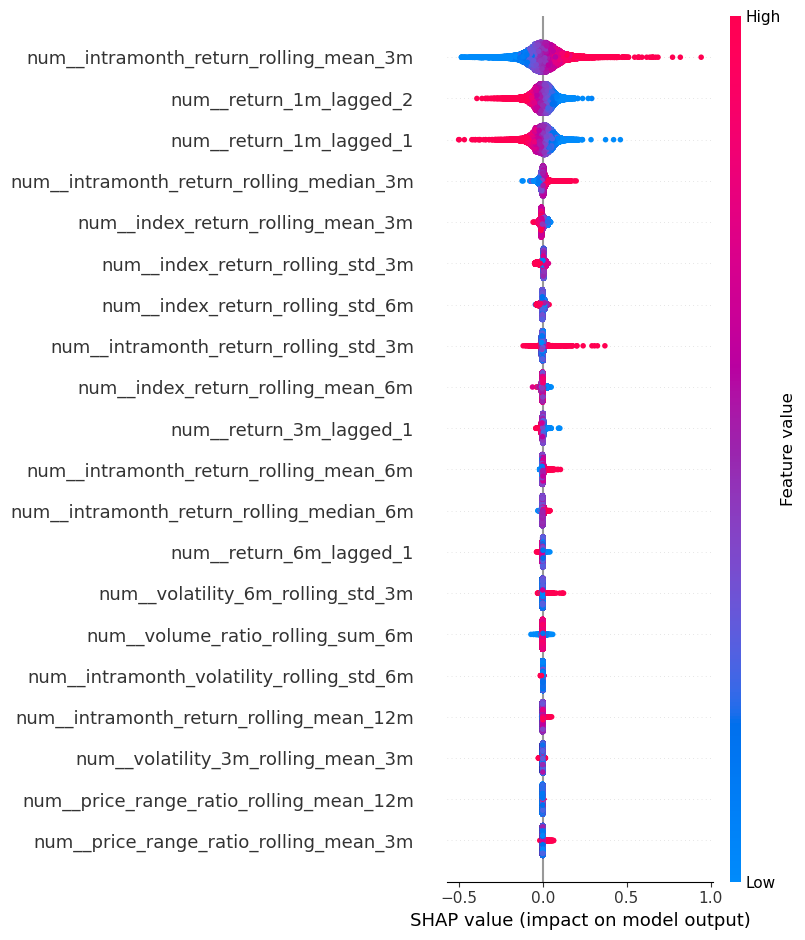

In [55]:
# Use the best tuned CatBoost model to compute SHAP values and plot the feature importance
explainer_cat = shap.TreeExplainer(catboost_best_estimator.named_steps["model"])
X_train_processed = catboost_best_estimator.named_steps["preprocessor"].transform(train_df)
shap_values_cat = explainer_cat.shap_values(X_train_processed)
shap.summary_plot(shap_values_cat, X_train_processed, feature_names=catboost_best_estimator.named_steps["preprocessor"].get_feature_names_out())

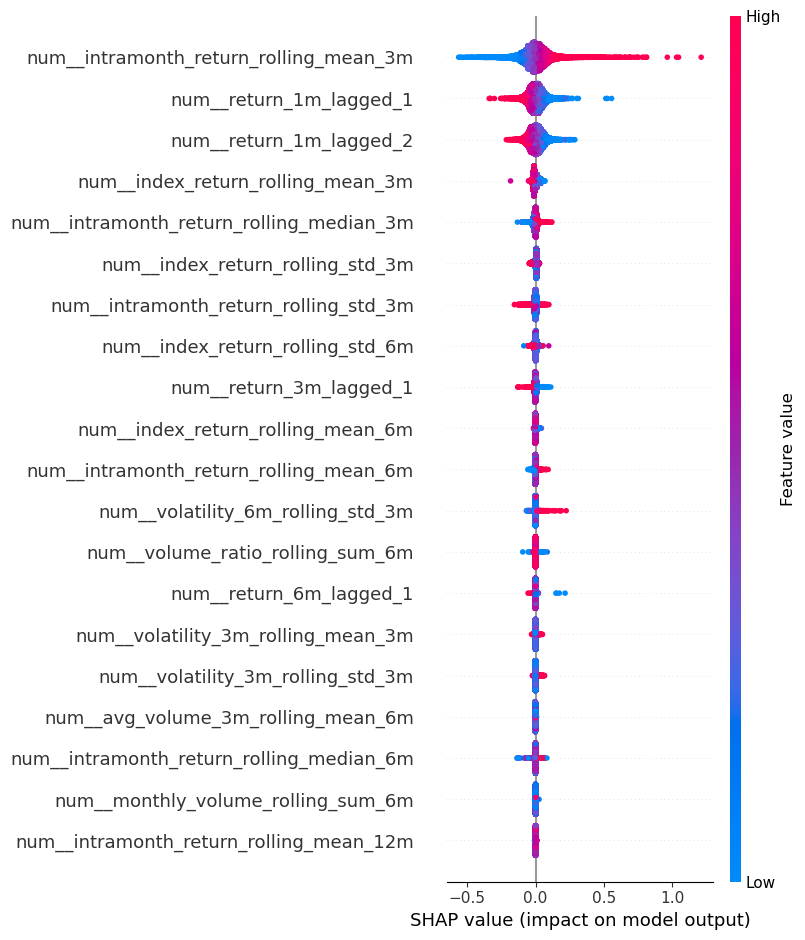

In [56]:
# Use the best tuned XGBoost model to compute SHAP values and plot the feature importance
explainer_xgb = shap.TreeExplainer(xgb_best_estimator.named_steps["model"])
X_train_processed = xgb_best_estimator.named_steps["preprocessor"].transform(train_df)
shap_values_xgb = explainer_xgb.shap_values(X_train_processed)
shap.summary_plot(shap_values_xgb, X_train_processed, feature_names=xgb_best_estimator.named_steps["preprocessor"].get_feature_names_out())

The SHAP feature importance rankings from CatBoost and XGBoost are largely consistent. With this ordering in hand, we can apply forward or backward feature selection to identify the point where adding more features stops improving performance or even starts to degrade it.

Since CatBoost is our strongest model, we use it for forward selection. To accelerate the process, we add features in batches of five rather than one at a time.

In [62]:
# Custom transformer to select top-k features based on importance
class TopKFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names, importances, k=20):
        self.feature_names = feature_names
        self.importances = importances
        self.k = k
        self.selected_idx = None

    def fit(self, X, y=None):
        ranking = np.argsort(self.importances)[::-1]
        self.selected_idx = ranking[:self.k]
        return self

    def transform(self, X):
        return X[:, self.selected_idx]

    def get_feature_names_out(self, input_features=None):
        return [self.feature_names[i] for i in self.selected_idx]

def feature_selection_curve_with_pipeline(base_pipeline, X, y, cv_splits, task, step=5):
    results = []

    # Get feature importances
    model = base_pipeline.named_steps["model"]
    importances = model.get_feature_importance()
    feature_names = base_pipeline.named_steps["preprocessor"].get_feature_names_out()

    sorted_idx = np.argsort(importances)[::-1]

    for k in range(step, len(sorted_idx) + 1, step):
        print(f"Training with {k} number of features...")
        selected_idx = sorted_idx[:k]

        metric_scores = []
        for train_idx, val_idx in cv_splits:
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            # Build fresh pipeline each time
            preprocessor = base_pipeline.named_steps["preprocessor"]
            cat_params = base_pipeline.named_steps["model"].get_params()
            cat_params["verbose"] = 0

            if task == "classification":
                    fs_pipeline = Pipeline(steps=[
                        ("preprocessor", preprocessor),
                        ("selector", TopKFeatureSelector(feature_names, importances, k=k)),
                        ("model", CatBoostClassifier(**cat_params))
                ])
            elif task == "regression":
                fs_pipeline = Pipeline(steps=[
                    ("preprocessor", preprocessor),
                    ("selector", TopKFeatureSelector(feature_names, importances, k=k)),
                    ("model", CatBoostRegressor(**cat_params))
                ])

            fs_pipeline.fit(X_train, y_train)
            y_pred = fs_pipeline.predict(X_val)
            if task == "classification":
                metric_scores.append(f1_score(y_val, y_pred))
            elif task == "regression":
                metric_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))

        results.append((k, np.mean(metric_scores)))

    return results



Training with 5 number of features...
Training with 10 number of features...
Training with 15 number of features...
Training with 20 number of features...
Training with 25 number of features...
Training with 30 number of features...
Training with 35 number of features...
Training with 40 number of features...
Training with 45 number of features...
Training with 50 number of features...
Training with 55 number of features...
Training with 60 number of features...
Training with 65 number of features...
Training with 70 number of features...


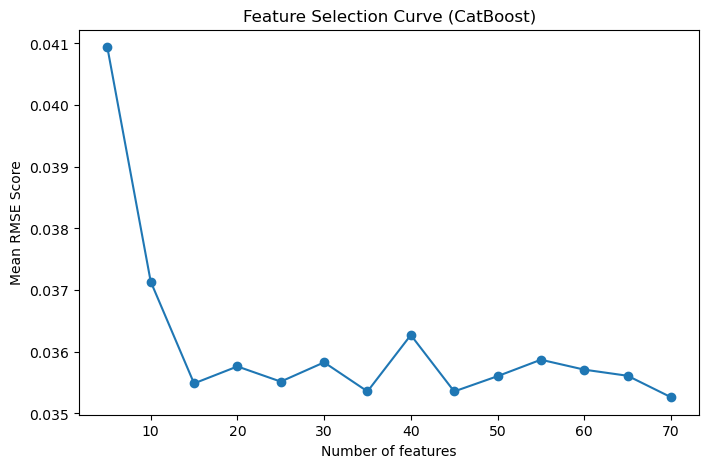

In [63]:
cv_splits = list(time_series_cv_splits(train_df, warmup=12, n_splits=30, window_type="expanding"))
results = feature_selection_curve_with_pipeline(catboost_best_estimator, X_train_clf, y_train_clf, cv_splits, task="regression", step=5)

ks, f1s = zip(*results)
plt.figure(figsize=(8,5))
plt.plot(ks, f1s, marker="o")
plt.xlabel("Number of features")
plt.ylabel("Mean RMSE Score")
plt.title("Feature Selection Curve (CatBoost)")
plt.show()

In [64]:
results

[(5, np.float64(0.040937892059317686)),
 (10, np.float64(0.037138207870915076)),
 (15, np.float64(0.03548606860594498)),
 (20, np.float64(0.03576141252068561)),
 (25, np.float64(0.03551540586567263)),
 (30, np.float64(0.03582774887411926)),
 (35, np.float64(0.035356145905082806)),
 (40, np.float64(0.03627078016367557)),
 (45, np.float64(0.035355922180760814)),
 (50, np.float64(0.03560340341235521)),
 (55, np.float64(0.03587030037953444)),
 (60, np.float64(0.0357093717343959)),
 (65, np.float64(0.03561009695319818)),
 (70, np.float64(0.03526224907064136))]

In [66]:
min(results, key=lambda x: x[1])

(70, np.float64(0.03526224907064136))

The best F1-score is achieved when using the top 70 features. However, this performance is identical to when we fit the model using all features. A closer look shows that the model improves sharply when using the first 10 features then beyond this point, the RMSE fluctuates around ~0.03 without meaningful gains. We can argue using the first 15 features might actually be the best scenario here.

Therefore, we select the top 15 features, which provides strong performance while greatly reducing model complexity.

## 8. Final Ensemble Model

From the validation results, we observed that all tuned models achieved similar RMSE scores, with some models performing slightly better than others in certain cases. However, relying on a single model risks misclassifying instances where another model might have been closer to the actual excess return value.

To address this, we build an ensemble model, which aggregates predictions from all models instead of depending on just one. By combining their strengths, the ensemble reduces variance, improves robustness, and increases the chance of making correct predictions. This serves as our final model for predicting the label.

In [73]:
def create_ensemble_pipeline(X_train, top_k_features):
    # Feature preprocessor
    categorical_features, ordinal_features, numerical_features = get_features(X_train)
    preprocessor = create_feature_preprocessor(categorical_features, ordinal_features, numerical_features)
    
    # Feature selector (top-k features)
    importances = catboost_best_estimator.named_steps["model"].get_feature_importance()
    feature_names = catboost_best_estimator.named_steps["preprocessor"].get_feature_names_out()
    feature_selector = TopKFeatureSelector(feature_names, importances, k=top_k_features)
    
    # Build ensemble models
    cat_model = catboost_best_estimator.named_steps["model"]
    xgb_model = xgb_best_estimator.named_steps["model"]
    rf_model  = rf_best_estimator.named_steps["model"]
    svm_model = svm_best_estimator.named_steps["model"]
    lr_model = logreg_best_estimator.named_steps["model"]

    # Voting classifier (soft = uses probabilities)
    ensemble_model = VotingRegressor(
        estimators=[
            ("cat", cat_model),
            ("xgb", xgb_model),
            ("rf", rf_model),
            ("svm", svm_model),
            ("lr", lr_model)
        ],
        n_jobs=-1
    )
    
    # Ensemble model pipeline
    ensemble_pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("feature_selector", feature_selector),
        ("model", ensemble_model)
    ])

    return ensemble_pipeline

In [76]:
def evaluate_pipeline(pipeline, X, y, n_splits, warmup=12, window_type="expanding"):
    oof_preds = np.zeros(len(X))
    scores = []

    for fold, (train_idx, val_idx) in enumerate(time_series_cv_splits(X, warmup, n_splits, window_type)):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

        pipeline.fit(X_train_cv, y_train_cv)
        preds = pipeline.predict(X_val_cv)
        oof_preds[val_idx] = preds

        rmse = np.sqrt(mean_squared_error(y_val_cv, preds))
        scores.append(rmse)
        print(f"Fold {fold+1}: RMSE = {rmse:.4f}")

    print(f"\nMean RMSE score across folds: {np.mean(scores):.4f}")
    return pipeline, scores

In [77]:
# Train an ensemble model with top 20 features we got from the feature importance
ensemble_pipeline = create_ensemble_pipeline(X_train_clf, top_k_features=15)
ensemble_pipeline, ensemble_scores = evaluate_pipeline(ensemble_pipeline, X_train_clf, y_train_clf, n_splits=30)

Fold 1: RMSE = 0.0536
Fold 2: RMSE = 0.0673
Fold 3: RMSE = 0.0518
Fold 4: RMSE = 0.0312
Fold 5: RMSE = 0.0427
Fold 6: RMSE = 0.0443
Fold 7: RMSE = 0.0337
Fold 8: RMSE = 0.0351
Fold 9: RMSE = 0.0324
Fold 10: RMSE = 0.0358
Fold 11: RMSE = 0.0376
Fold 12: RMSE = 0.0367
Fold 13: RMSE = 0.0391
Fold 14: RMSE = 0.0391
Fold 15: RMSE = 0.0438
Fold 16: RMSE = 0.0381
Fold 17: RMSE = 0.0441
Fold 18: RMSE = 0.0426
Fold 19: RMSE = 0.0350
Fold 20: RMSE = 0.0476
Fold 21: RMSE = 0.0308
Fold 22: RMSE = 0.0438
Fold 23: RMSE = 0.0405
Fold 24: RMSE = 0.0447
Fold 25: RMSE = 0.0432
Fold 26: RMSE = 0.0260
Fold 27: RMSE = 0.0331
Fold 28: RMSE = 0.0282
Fold 29: RMSE = 0.0493
Fold 30: RMSE = 0.0355

Mean RMSE score across folds: 0.0402


We can save our final ensemble model for future predictions.

In [78]:
with open("../files/models/classification/final_voting_classifier.pkl", "wb") as f:
    pickle.dump(ensemble_pipeline, f)

Now, let's try predicting the `excess_return` label using the saved ensemble model on the test set.

In [80]:
with open("../files/models/regression/final_voting_classifier.pkl", 'rb') as file:
    ensemble_pipeline = pickle.load(file)

submission_df = X_test_clf[["month_id", "stock_id"]]
submission_df["excess_return"] = ensemble_pipeline.predict(X_test_clf)
submission_df.head()

C:\Users\Archel\AppData\Local\Temp\ipykernel_20044\2720451253.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_df["excess_return"] = ensemble_pipeline.predict(X_test_clf)


,month_id,stock_id,excess_return
25618,2023_07,US001,-0.012496
25619,2023_07,US002,-0.011014
25620,2023_07,US003,-0.003824
25621,2023_07,US004,0.001195
25622,2023_07,US005,0.008390


<Axes: ylabel='Frequency'>

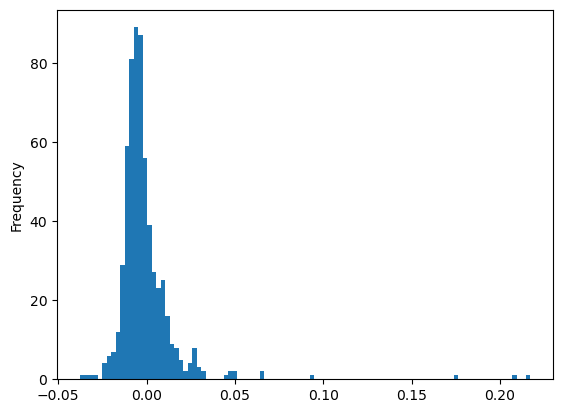

In [83]:
submission_df["excess_return"].plot(kind="hist", bins=100)

As we can see, the final prediction is similar with the normal distribution on the actual ground truth labels with mean 0 and standard deviation of 0.25.